# Plotting the Laplacian eigenfunctions

In [1]:
from utils import *
from grid import make_grid

# 4 rooms grid, goals in center of the rooms
height = 100
width = 100
goals = [[25, 25]]

# Define walls
walls = []
for j in range(10):
    for i in range(100):
        walls += [[45 + j, i], [i, 45 + j]]
doors = []
for j in range(10):
    for i in range(10):
         doors += [[45 + j, 20+i], [20 + i, 45 + j], [45 + j, 70 + i], [70+j, 45 + i]]

In [2]:
grid_world = make_grid(height, width, goals, walls=walls, doors=doors)

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


In [3]:
horizon = 100
n_episodes = 1000

data = collect_episodes(grid_world, horizon=horizon, n_episodes=n_episodes)

In [4]:
states = np.array([data[i][0] for i in range(len(data))])

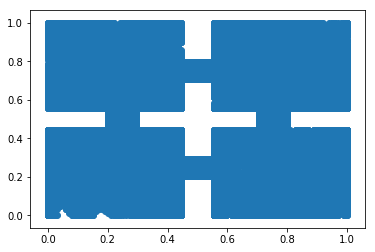

In [5]:
plt.scatter(states[:,0], states[:,1])

In [18]:
# Subsample to build pvfs
graph_states = subsample([data[i][0] for i in range(len(data))], 0.05)

In [19]:
from basis import ProtoValueBasis
num_eig = 15
var = 0.1
nn = 20
print('Computing the Laplacian')
# Learn state manifold
basis = ProtoValueBasis(graph_states, var, nn, 4)
print('Laplacian computed')
basis.set_num_features(num_eig)

Computing the Laplacian
Laplacian computed


In [9]:
class ManifoldPlot(object):
    
    def __init__(self, pvfs, env, state_indexes, **args):
        self.state_indexes = state_indexes
        self.low = env.observation_space.low
        self.high = env.observation_space.high
        self.env = env
        self.pvfs = pvfs
        self.args = args
        self._compute_phis()
        
    def _compute_phis(self):
        X = np.linspace(self.low[self.state_indexes[0]], self.high[self.state_indexes[0]], 10)
        Y = np.linspace(self.low[self.state_indexes[1]], self.high[self.state_indexes[1]], 10)
        X, Y = np.meshgrid(X, Y)
        self.phis = np.array([self.func(x,y) for x,y in zip(np.ravel(X), np.ravel(Y))])
        self.X, self.Y = X, Y
        
    def func(self, x, y):
        s = np.zeros(self.env.observation_space.shape[0])
        s[self.state_indexes[0]] = x
        s[self.state_indexes[1]] = y
        return self.pvfs.evaluate(s)[0, :self.pvfs.k]
        
    def plot_embedding(self, eigens):
        fig = plt.figure(figsize=(10,10))
        n = len(eigens)
        rows = n//3 + 1
        for i, j in enumerate(eigens):
            ax = fig.add_subplot(rows, 3, i+1, projection='3d')
            zs = self.phis[:,j]
            Z = zs.reshape(self.X.shape)

            ax.plot_surface(self.X, self.Y, Z, cmap=cm.coolwarm)

            ax.set_xlabel(self.args['X'])
            ax.set_ylabel(self.args['Y'])
            ax.set_zlabel(self.args['Z'])
            lambd = round(self.pvfs.eigenvals[j], 2)
            ax.set_title(r'$\phi$ ' + str(j+1) + ', lambda %s'%lambd)
        plt.tight_layout()


In [20]:
# Display the embeding of the state space
d = {'X':'X', 'Y':'Y', 'Z':'Value of eigenfunction'}
manplot = ManifoldPlot(basis, grid_world, [0,1], **d)

In [22]:
%matplotlib qt
eigens = [4, 5, 6]
manplot.plot_embedding(eigens)